<a href="https://colab.research.google.com/github/Rohit-Singh12/Deep-LEARGNINGS/blob/main/Misc/MemoryPinning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Memory Pinning
Memory pinning improved performance by reducing the time required from transfering the data from CPU to GPU.

When using a GPU, PyTorch needs to transfer your training data from CPU memory to GPU memory (**VRAM**).

Normally:
**Data is in pagable memory, and transferring it to GPU is slower.**

With memory pinning, **Data is allocated in page-locked (pinned) memory, which allows faster DMA (Direct Memory Access) transfers to GPU.**

In [1]:
!pip install pytorch-lightning torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 52.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
full_train = FashionMNIST(root='data', train=True, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.43MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.74MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.3MB/s]


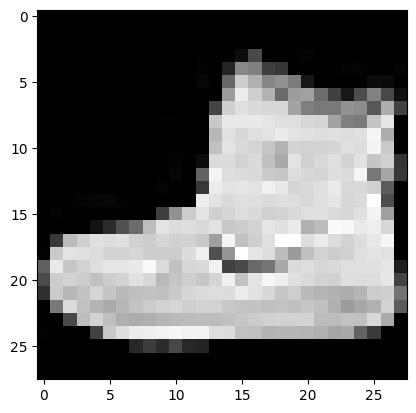

In [5]:
import matplotlib.pyplot as plt

img = full_train.data[0]
img = img.squeeze()
plt.imshow(img, cmap='gray')

In [6]:
img.shape

torch.Size([28, 28])

In [7]:
len(full_train)

60000

In [8]:
train_set, val_set = random_split(full_train, [54000, 6000])

In [9]:
len(train_set), len(val_set)

(54000, 6000)

In [10]:
batch_size = 64

In [11]:
train_set = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [12]:
val_set = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [13]:
test_set = FashionMNIST('root', train=False, transform=transform, download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.29MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.5MB/s]


In [14]:
len(test_set)

10000

In [15]:
test_set = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [17]:
full_train.classes, len(full_train.classes)

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 10)

In [18]:
num_classes = len(full_train.classes)

In [19]:
class Model(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.max_pool = nn.MaxPool2d(2, 2) #output [batch_size, 64, 14, 14]
    self.fc1 = nn.Linear(64*14*14, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.max_pool(x)
    #flatten the x
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return x

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=1e-3)

  def training_step(self, batch, batch_idx):
    X, y = batch
    # print(f"Device: {X.device}")
    y_hat = self(X)
    loss = F.cross_entropy(y_hat, y)
    acc = (y_hat.argmax(dim=1) == y).float().mean()
    self.log('train_loss', loss, prog_bar=True)
    self.log('train_acc', acc, prog_bar=True)
    return loss

  def validation_step(self, batch, batch_size):
    X, y = batch
    y_hat = self(X)
    loss = F.cross_entropy(y_hat, y)
    acc = (y_hat.argmax(dim=1) ==y).float().mean()
    self.log("val_acc", acc, prog_bar=True)

  def test_step(self, batch, batch_size):
    X, y = batch
    y_hat = self(X)
    loss = F.cross_entropy(y_hat, y)
    acc = (y_hat.argmax(dim=1)==y).float().mean()
    self.log("test_acc", acc, prog_bar=True)



In [20]:
model = Model()
trainer = pl.Trainer(
    max_epochs=10,
    accelerator='gpu',
    devices=1,
    profiler='simple'
)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [21]:
trainer.fit(model, train_dataloaders=train_set, val_dataloaders=val_set)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type      | Params | Mode 
-----------------------------------------------
0 | conv1    | Conv2d    | 320    | train
1 | conv2    | Conv2d    | 18.5 K | train
2 | max_pool | MaxPool2d | 0      | train
3 | fc1      | Linear    | 1.6 M  | train
4 | fc2      | Linear    | 1.3 K  | train
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.503     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.profilers.profiler:FIT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                             

In [22]:
trainer.test(model, dataloaders=train_set)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9903148412704468     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.profilers.profiler:TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                       

[{'test_acc': 0.9903148412704468}]

Total Training time: **197 secs**

# Memory Pinning to reduce Training Time

In [40]:
class MyModel(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.max_pool = nn.MaxPool2d(2, 2) #output [batch_size, 64, 14, 14]
    self.fc1 = nn.Linear(64*14*14, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.max_pool(x)
    #flatten the x
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return x

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=1e-3)

  def training_step(self, batch, batch_idx):
    X, y = batch
    # print(f"Device: {X.device}")
    y_hat = self(X)
    loss = F.cross_entropy(y_hat, y)
    acc = (y_hat.argmax(dim=1) == y).float().mean()
    self.log('train_loss', loss, prog_bar=True)
    self.log('train_acc', acc, prog_bar=True)
    return loss

  def validation_step(self, batch, batch_size):
    X, y = batch
    y_hat = self(X)
    loss = F.cross_entropy(y_hat, y)
    acc = (y_hat.argmax(dim=1) ==y).float().mean()
    self.log("val_acc", acc, prog_bar=True)

  def test_step(self, batch, batch_size):
    X, y = batch
    y_hat = self(X)
    loss = F.cross_entropy(y_hat, y)
    acc = (y_hat.argmax(dim=1)==y).float().mean()
    self.log("test_acc", acc, prog_bar=True)



In [41]:
train_data, val_data = random_split(full_train, [54000, 6000])
len(train_data),len(val_data)

(54000, 6000)

### To utilize memory pinning use ```pin_memory=True``` and ```num_workers>0```
*NOTE: Make sure to set the num_workers not too high that can be handled by CPU. If you CPU has 2 logical processor, num_workers shouldn't be > 2 else it will slow down training*

In [42]:
train_data = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
val_data = DataLoader(val_data, batch_size=batch_size, pin_memory=True, num_workers=2)

In [43]:
model = MyModel()
trainer = pl.Trainer(
    max_epochs=10,
    accelerator='gpu',
    devices=1,
    profiler='simple'
)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [44]:
trainer.fit(model, train_dataloaders=train_data, val_dataloaders=val_data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type      | Params | Mode 
-----------------------------------------------
0 | conv1    | Conv2d    | 320    | train
1 | conv2    | Conv2d    | 18.5 K | train
2 | max_pool | MaxPool2d | 0      | train
3 | fc1      | Linear    | 1.6 M  | train
4 | fc2      | Linear    | 1.3 K  | train
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.503     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.profilers.profiler:FIT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                             

**Training time is now 172 secs**